In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import datetime
import os
from sklearn.metrics import mean_squared_error
test_symbols = ["CTXR", "IBIO", "MNKD", "IMGN", "ATOS", "SPPI"]
model_settings = {'epochs': 50, 'batch_size': 100, 'train_test_ratio': 0.7, 'hidden_layers': 3, 'units': 100, 'n_lags': 2}

# Choose what Symbol you would like to predict:
symbol = 'CTXR'     # change to whatever symbol in your dataframe you'd like to attempt to predict.
start_date = "2020-01-01"
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_settings['start_date'] = start_date
model_settings['end_date'] = current_date

# next cell
conn = sqlite3.connect('stockPrediction_062721.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{symbol}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

# next
# reset the index
df = df.reset_index()

# next
# convert to datetime
df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

# reshape
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[start_date:current_date]  # date range from 2019-01-01 to 2021-05-31

# set a threshold of how many np.nan you are willing to work with
close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

# forward fill in np.nan values in columns not previously dropped.
close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)



In [2]:
# splitting test/training data
data_size = len(close_df)

# using a 90/10 train/test split
training_data = close_df.iloc[:(int(data_size * model_settings['train_test_ratio']))]
test_data = close_df.iloc[(int(data_size * model_settings['train_test_ratio'])):]

# First, create a singular dataframe from the symbol you would like to predict vaues for
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()

minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)

train_scaled = train_scaled.values
# n_lags = int(60) # not sure why hard 60
# n_lags = int(30)
X_train = []
y_train = []
for i in range(model_settings['n_lags'], train_scaled.shape[0]):
    X_train.append(train_scaled[i-model_settings['n_lags']:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))



In [3]:
# prep test data early, so I can get validation loss info?
# next part may not be necessary:
total_data = pd.concat((training_data, test_data), axis=0)
# inputs = total_data[len(total_data) - len(test_data) - 60:]
inputs = total_data[len(total_data) - len(test_data) - model_settings['n_lags']:]
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
# print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(model_settings['n_lags'], test_scaled.shape[0]):
    X_test.append(test_scaled[i-model_settings['n_lags']:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

In [4]:
# TRAINING THE MODEL

# LSTM architecture
regressor = tf.keras.Sequential()

# First layer, w/ dropout regularization
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(tf.keras.layers.Dropout(0.2))

# Second
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

# Third
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.5))

# Fourth
regressor.add(tf.keras.layers.LSTM(units=model_settings['units']))
regressor.add(tf.keras.layers.Dropout(0.5))

# Output layer
regressor.add(tf.keras.layers.Dense(units=1))

# Compile LSTM
regressor.compile(optimizer='adam', loss='mean_squared_error')



In [5]:
# Fit to Training set
# fit to training set
# TBH I don't really understand why we iterate over the columns for this training; 
# we're not changing the data that gets fed to the model in these iterations, we're just repeating it
# going to comment this part out, just try doing it once
'''num_features = len(training_data.columns)
progress = 1
for i in training_data.columns:
    print("Fitting to", i)
    print("Training feature", progress, "of", num_features)
    regressor.fit(X_train, y_train, epochs=model_settings['epochs'], batch_size=model_settings['batch_size'], verbose=0)
    progress += 1'''

print("training model...")
regressor.fit(X_train, y_train, epochs=model_settings['epochs'], batch_size=model_settings['batch_size'], verbose=0, validation_data=(X_test, y_test), shuffle=True)

print("Saving Model...")
regressor.save(f"model_{current_datetime}")
print("Model Saved.")



training model...
Saving Model...
INFO:tensorflow:Assets written to: model_20210627_162534\assets
INFO:tensorflow:Assets written to: model_20210627_162534\assets
Model Saved.


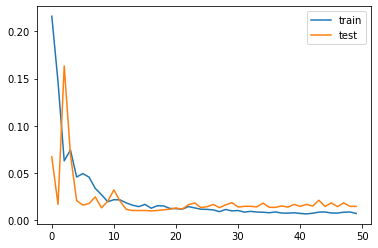

In [6]:
plt.plot(regressor.history.history['loss'], label='train')
plt.plot(regressor.history.history['val_loss'], label='test')
plt.legend()
plt.savefig(f'test_train_loss_{current_datetime}_epochs{model_settings["epochs"]}_batchsize{model_settings["batch_size"]}_units{model_settings["units"]}_')

<ipython-input-7-a98c3584054c>:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mse_values = pd.Series()
Shape of test data: (115, 438)
Shape of test data: (115, 438)
Shape of test data: (115, 438)
Shape of test data: (115, 438)
Shape of test data: (115, 438)
Shape of test data: (115, 438)


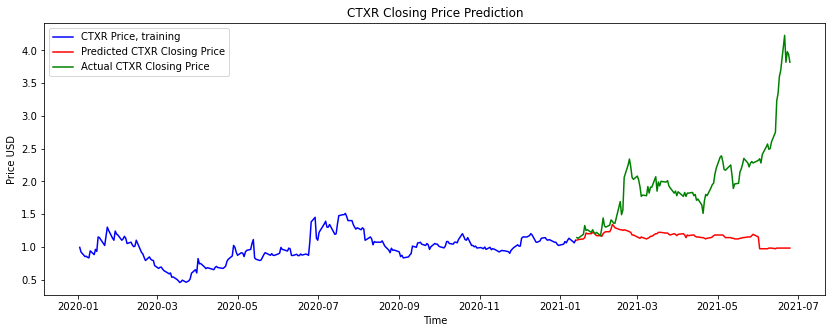

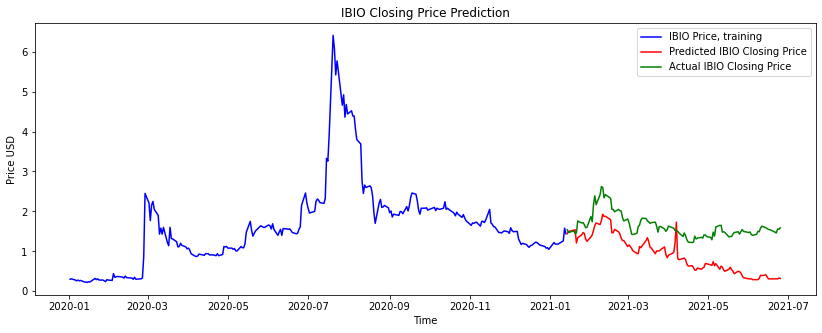

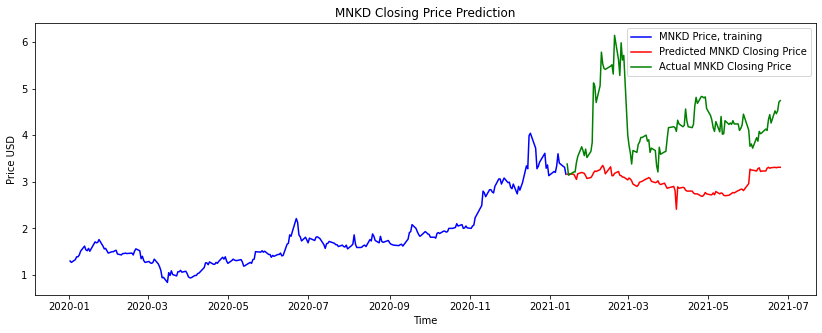

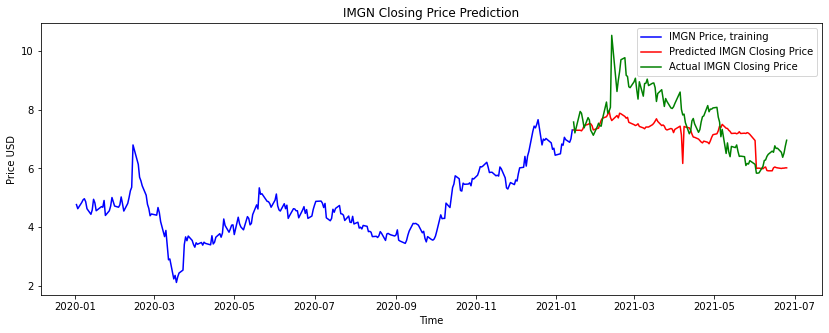

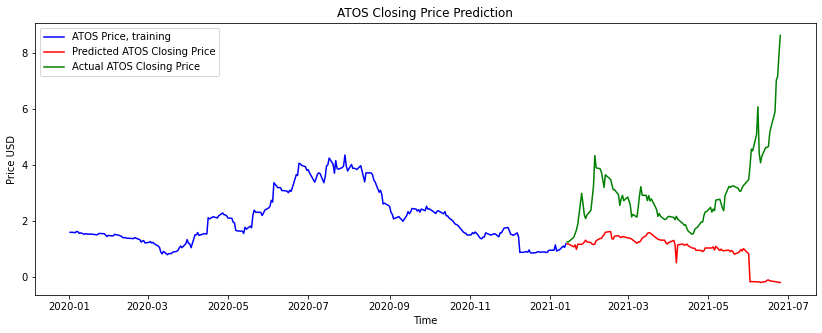

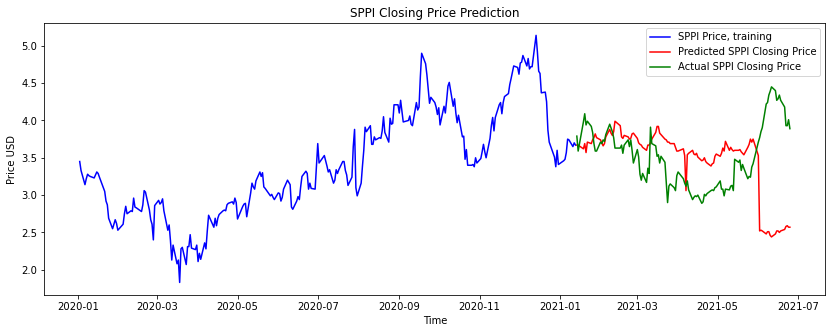

In [7]:
# next part may not be necessary:
total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - model_settings['n_lags']:]
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
# print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(model_settings['n_lags'], test_scaled.shape[0]):
    X_test.append(test_scaled[i-model_settings['n_lags']:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=2)
predicted_price.index = test_data.index     # end of possibly not necessary code

# now onto the test

directory = f"test_plots_{current_datetime}"
parent_dir = r"C:\Users\james\Dropbox\Box Sync\code\stockPrediction"

path = os.path.join(parent_dir, directory)
if os.path.exists(path):
    pass
else:
    os.mkdir(path)

mse_values = pd.Series()
model_settings_pd = pd.Series(model_settings)
model_settings_pd.to_csv(f"{path}/{current_datetime}_model_settings.csv")

for symbol in test_symbols:
    # First, create a singular dataframe from the symbol you would like to predict vaues for
    training_data_predicted = training_data[symbol]
    training_data_predicted = training_data_predicted.to_frame()

    minmax = MinMaxScaler(feature_range=(0,1))
    minmax_single = MinMaxScaler(feature_range=(0,1))

    # Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
    training_data = training_data.drop(columns=symbol)
    train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

    columns = [i for i in training_data.columns]
    columns.append(symbol)

    # I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
    training_data[symbol] = training_data_predicted[symbol]

    train_scaled = pd.DataFrame(train_scaled, columns=columns)

    # this section may not be necessary
    train_scaled = train_scaled.values
    # n_lags = int(60) # not sure why hard 60
    X_train = []
    y_train = []
    for i in range(model_settings['n_lags'], train_scaled.shape[0]):
        X_train.append(train_scaled[i-model_settings['n_lags']:i])
        y_train.append(train_scaled[i,0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

    # this may also not be necessary

    total_data = pd.concat((training_data, test_data), axis=0)
    inputs = total_data[len(total_data) - len(test_data) - model_settings['n_lags']:]
    # inputs = data[len(data) - len(test_data) - 60:]

    predicted_input = inputs[symbol].to_frame()
    inputs = inputs.drop(columns=symbol)

    test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
    print('Shape of test data:', test_scaled.shape)

    # shaping test data from neural network
    X_test = []
    y_test = []
    for i in range(model_settings['n_lags'], test_scaled.shape[0]):
        X_test.append(test_scaled[i-model_settings['n_lags']:i])
        y_test.append(test_scaled[i,0])

    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

    # this part is absolutely necessary
    predicted_price = regressor.predict(X_test)
    predicted_price = minmax_single.inverse_transform(predicted_price)
    predicted_price = pd.DataFrame(predicted_price)
    predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
    predicted_price = predicted_price.round(decimals=2)
    predicted_price.index = test_data.index

    # this below shifts the data to align w/ the last point in the training data
    # this may not get used
    last_value = training_data[symbol].iloc[-1]
    difference = last_value - predicted_price[f'{symbol}_predicted'].iloc[0]
    predicted_price[f'{symbol}_predicted'] = predicted_price[f'{symbol}_predicted'] + difference

    # plot
    plt.figure(figsize=(14,5))
    #mse = mean_squared_error(y_test, predicted_price)
    plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
    plt.plot(predicted_price[f'{symbol}_predicted'], color = 'red', label= f'Predicted {symbol} Closing Price')
    plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
    # plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
    plt.title(f'{symbol} Closing Price Prediction')
    plt.xlabel("Time")
    plt.ylabel('Price USD')
    plt.legend()
    plt.savefig(f"{path}/{symbol}_{current_datetime}")

    mse = mean_squared_error(test_data[symbol], predicted_price[f'{symbol}_predicted'])
    mse_values[symbol] = mse

mse_values.to_csv(f"{path}/{current_datetime}_mse.csv")

Shape of test data: (166, 412)


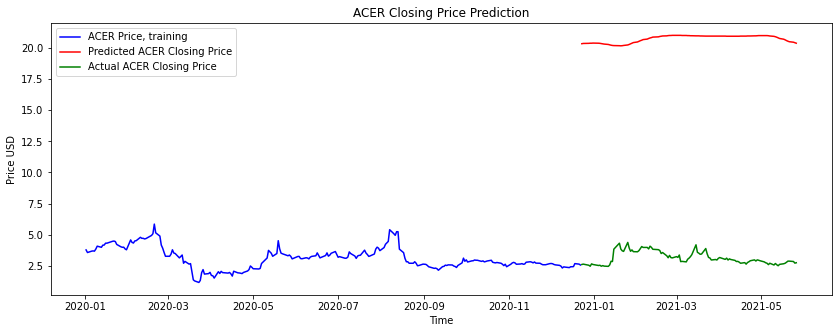

In [8]:
# this cell is experimental; going to try to shift the prediction up to the last point of the train data
# start w/ the same stuff
symbol = 'ACER'

# first, we need to redo our training/test data sets to predict accurately
# otherwise, we are scaling one symbol based on another
# we start w/ the pre-training code that prepares the data

# First, create a singular dataframe from the symbol you would like to predict vaues for
# We need to create this df separate from the other df, so that we can feed a single symbol's data into the scaler when making predictions
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()

minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)

# reshape data into an np.array
train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
# shape of len, sequence, features
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

# now, reshaping data for testing based on training data

total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

# this part is absolutely necessary
predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=2)
predicted_price.index = test_data.index

# plot
plt.figure(figsize=(14,5))
#mse = mean_squared_error(y_test, predicted_price)
plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
plt.plot(predicted_price[f'{symbol}_predicted'], color = 'red', label= f'Predicted {symbol} Closing Price')
plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
# plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
plt.title(f'{symbol} Closing Price Prediction')
plt.xlabel("Time")
plt.ylabel('Price USD')
plt.legend()

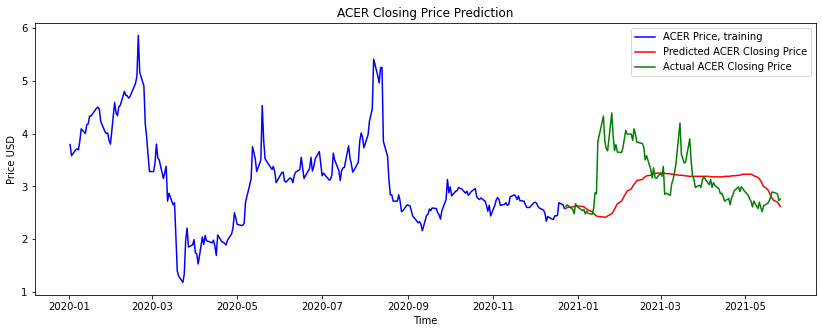

In [9]:
# this is where the real experiment starts
# take the last value of the train set, find the difference between that and the test set, and either add/subtract the whole df based on that amt
# kinda sketchy, but hey we'll see how it does
last_value = training_data[symbol].iloc[-1]
difference = last_value - predicted_price[f'{symbol}_predicted'].iloc[0]
predicted_price[f'{symbol}_predicted'] = predicted_price[f'{symbol}_predicted'] + difference

# plot
plt.figure(figsize=(14,5))
#mse = mean_squared_error(y_test, predicted_price)
plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
plt.plot(predicted_price[f'{symbol}_predicted'], color = 'red', label= f'Predicted {symbol} Closing Price')
plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
# plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
plt.title(f'{symbol} Closing Price Prediction')
plt.xlabel("Time")
plt.ylabel('Price USD')
plt.legend()

In [5]:
# place the symbol you'd like to predict in here
symbol = 'ACER'

# first, we need to redo our training/test data sets to predict accurately
# otherwise, we are scaling one symbol based on another
# we start w/ the pre-training code that prepares the data

# First, create a singular dataframe from the symbol you would like to predict vaues for
# We need to create this df separate from the other df, so that we can feed a single symbol's data into the scaler when making predictions
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()

minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)

# reshape data into an np.array
train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
# shape of len, sequence, features
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

# now, reshaping data for testing based on training data

total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))



Shape of test data: (166, 412)


In [6]:
# this part is absolutely necessary
predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=2)
predicted_price.index = test_data.index

# plot
plt.figure(figsize=(14,5))
#mse = mean_squared_error(y_test, predicted_price)
plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
plt.plot(predicted_price[f'{symbol}_predicted'], color = 'red', label= f'Predicted {symbol} Closing Price')
plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
# plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
plt.title(f'{symbol} Closing Price Prediction')
plt.xlabel("Time")
plt.ylabel('Price USD')
plt.legend()

KeyboardInterrupt: 

# Predictions from all data, no tests to verify, start below

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import datetime
import os
from sklearn.metrics import mean_squared_error
test_symbols = ["CTXR", "IBIO", "MNKD", "IMGN", "ATOS", "SPPI"]
model_settings = {'epochs': 50, 'batch_size': 4, 'train_test_ratio': 0.7, 'hidden_layers': 3, 'units': 100, 'n_lags': 2}

# Choose what Symbol you would like to predict:
symbol = 'CTXR'     # change to whatever symbol in your dataframe you'd like to attempt to predict.
start_date = "2020-01-01"
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_settings['start_date'] = start_date
model_settings['end_date'] = current_date

# next cell
conn = sqlite3.connect('stockPrediction_062721.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{symbol}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

# next
# reset the index
df = df.reset_index()

# next
# convert to datetime
df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

# reshape
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[start_date:current_date]  # date range from 2019-01-01 to 2021-05-31

# set a threshold of how many np.nan you are willing to work with
close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

# forward fill in np.nan values in columns not previously dropped.
close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)



In [2]:
# splitting test/training data
data_size = len(close_df)

# training_data = close_df.iloc[:(int(data_size * model_settings['train_test_ratio']))]
# test_data = close_df.iloc[(int(data_size * model_settings['train_test_ratio'])):]
training_data = close_df

# First, create a singular dataframe from the symbol you would like to predict vaues for
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()

minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# scale data
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)

train_scaled = train_scaled.values
n_lags = model_settings['n_lags'] # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))



In [3]:
# TRAINING THE MODEL

# LSTM architecture
regressor = tf.keras.Sequential()

# First layer, w/ dropout regularization
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(tf.keras.layers.Dropout(0.2))

# Second
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

# Third
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.5))

# Fourth
regressor.add(tf.keras.layers.LSTM(units=model_settings['units']))
regressor.add(tf.keras.layers.Dropout(0.5))

# Output layer
# based on other tutorials, setting Dense units to # of days outward I would like to predict
regressor.add(tf.keras.layers.Dense(units=1, activation='linear'))

# Compile LSTM
regressor.compile(optimizer='adam', loss='mean_squared_error')



training model...
Saving Model...
INFO:tensorflow:Assets written to: model_20210627_184839\assets
INFO:tensorflow:Assets written to: model_20210627_184839\assets
Model Saved.


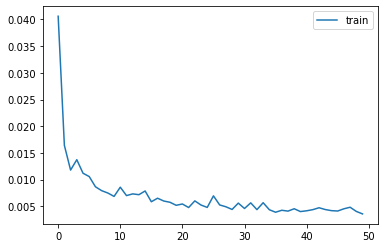

In [4]:
print("training model...")
regressor.fit(X_train, y_train, epochs=model_settings['epochs'], batch_size=model_settings['batch_size'], verbose=0, shuffle=True)

print("Saving Model...")
regressor.save(f"model_{current_datetime}")
print("Model Saved.")

plt.plot(regressor.history.history['loss'], label='train')
# plt.plot(regressor.history.history['val_loss'], label='test')
plt.legend()

In [5]:
# shape data to predict w/ 
'''# First, create a singular dataframe from the symbol you would like to predict vaues for
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()

minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)

# this section may not be necessary
train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

# this may also not be necessary'''

total_data = training_data
# inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = total_data[len(total_data) - 60:]
inputs = total_data
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(n_lags, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))



Shape of test data: (374, 438)


In [6]:
# this will require some manually debugging, I'm sure of it

# this part is absolutely necessary
predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=2)
# predicted_price.index = test_data.index



In [7]:
predicted_price

,CTXR_predicted
0,2.52
1,2.58
2,2.64
3,2.58
4,2.50
...,...
367,1.33
368,1.29
369,1.28
370,1.28


In [8]:
total_data = total_data.reset_index()
for i in range(len(predicted_price)):
    try:
        future_date = predicted_price['price_datetime'].iloc[i -1] + datetime.timedelta(days=1)
    except:
        future_date = total_data.price_datetime.iloc[-1] + datetime.timedelta(days=1)
    
    while future_date.weekday() in [5,6]:
        future_date = future_date + datetime.timedelta(days=1)
    future_date = future_date.strftime('%Y-%m-%d')
    future_date = pd.to_datetime(future_date, format='%Y-%m-%d')
    future_dates = {'price_datetime': future_date}
    '''try:
        future_dates_df = future_dates_df.append(future_dates, ignore_index=True)
    except:
        future_dates_df = pd.DataFrame.from_dict(future_dates)'''
    predicted_price = predicted_price.append(future_dates, ignore_index=True)
    predicted_price['price_datetime'].iloc[i] = future_date
# predicted_price['price_datetime'] = future_dates_df['price_datetime']


C:\Users\james\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [9]:
predicted_price = predicted_price.set_index('price_datetime')
predicted_price = predicted_price.dropna()
predicted_price

,CTXR_predicted
price_datetime,
2021-06-28,2.52
2021-06-29,2.58
2021-06-30,2.64
2021-07-01,2.58
2021-07-02,2.50
...,...
2022-11-23,1.33
2022-11-24,1.29
2022-11-25,1.28


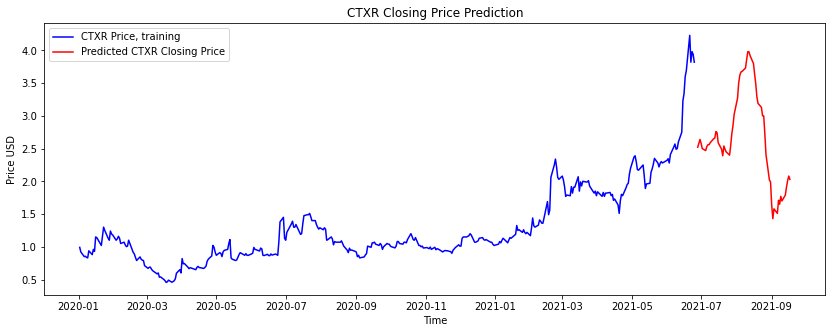

In [10]:
# plot
plt.figure(figsize=(14,5))
#mse = mean_squared_error(y_test, predicted_price)
plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
plt.plot(predicted_price[f'{symbol}_predicted'].iloc[:60], color = 'red', label= f'Predicted {symbol} Closing Price')
# plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
# plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
plt.title(f'{symbol} Closing Price Prediction')
plt.xlabel("Time")
plt.ylabel('Price USD')
plt.legend()
# plt.savefig(f"{path}/{symbol}_{current_datetime}")

# mse = mean_squared_error(test_data[symbol], predicted_price[f'{symbol}_predicted'])
# print('MSE for ', symbol, mse)
# mse_values[symbol] = mse

# mse_values.to_csv(f"{path}/{current_datetime}_mse.csv")

Shape of test data: (374, 438)
C:\Users\james\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
Shape of test data: (374, 438)
C:\Users\james\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
Shape of test data: (374, 438)
C:\Users\james\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

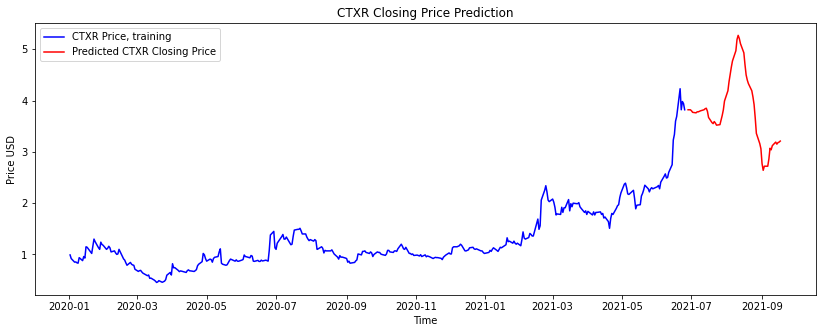

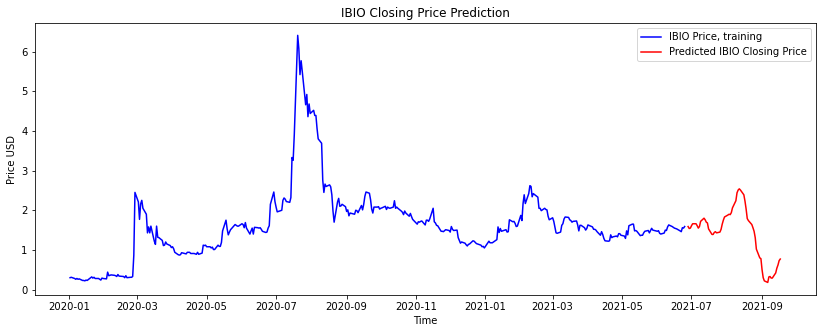

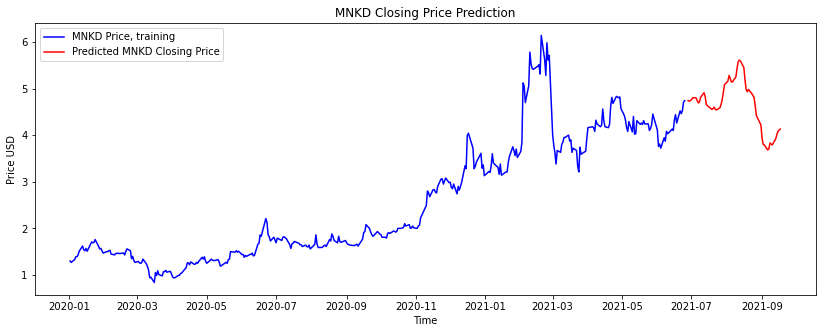

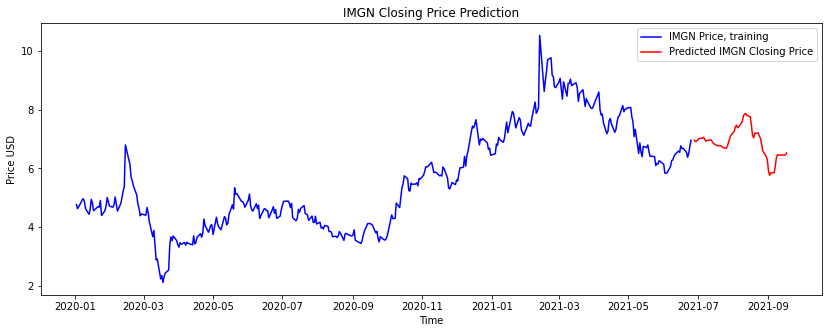

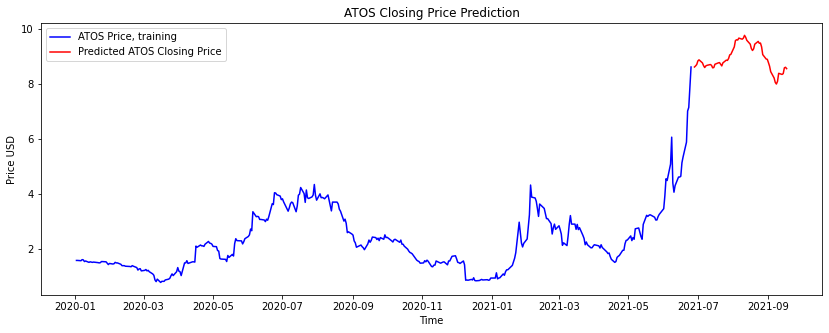

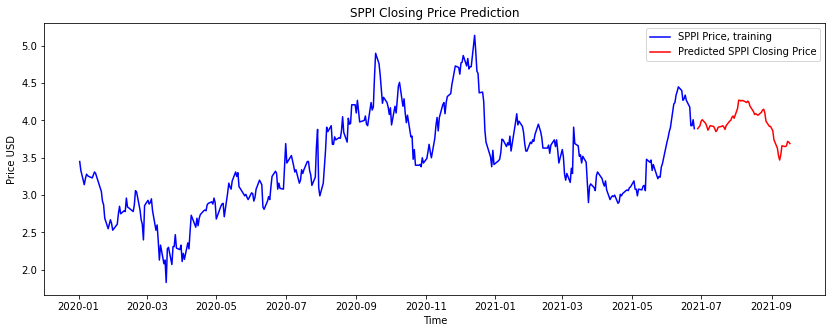

In [5]:
# test loop to look at some various symbols and make predictions
# not complete really, just to kinda see what happens
for symbol in test_symbols:
    # shape data to predict w/ 
    # First, create a singular dataframe from the symbol you would like to predict vaues for
    training_data_predicted = training_data[symbol]
    training_data_predicted = training_data_predicted.to_frame()

    minmax = MinMaxScaler(feature_range=(0,1))
    minmax_single = MinMaxScaler(feature_range=(0,1))

    # Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
    training_data = training_data.drop(columns=symbol)
    train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

    columns = [i for i in training_data.columns]
    columns.append(symbol)

    # I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
    training_data[symbol] = training_data_predicted[symbol]

    train_scaled = pd.DataFrame(train_scaled, columns=columns)

    # this section may not be necessary
    train_scaled = train_scaled.values
    n_lags = model_settings['n_lags'] # not sure why hard 60
    X_train = []
    y_train = []
    for i in range(n_lags, train_scaled.shape[0]):
        X_train.append(train_scaled[i-n_lags:i])
        y_train.append(train_scaled[i,0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

    # this may also not be necessary

    total_data = training_data
    # inputs = total_data[len(total_data) - len(test_data) - 60:]
    # inputs = total_data[len(total_data) - 60:]
    inputs = total_data
    # inputs = data[len(data) - len(test_data) - 60:]

    predicted_input = inputs[symbol].to_frame()
    inputs = inputs.drop(columns=symbol)

    test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
    print('Shape of test data:', test_scaled.shape)

    # shaping test data from neural network
    X_test = []
    y_test = []
    for i in range(n_lags, test_scaled.shape[0]):
        X_test.append(test_scaled[i-n_lags:i])
        y_test.append(test_scaled[i,0])

    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

    # this will require some manually debugging, I'm sure of it

    # this part is absolutely necessary
    predicted_price = regressor.predict(X_test)
    predicted_price = minmax_single.inverse_transform(predicted_price)
    predicted_price = pd.DataFrame(predicted_price)
    predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
    predicted_price = predicted_price.round(decimals=2)
    # predicted_price.index = test_data.index

    total_data = total_data.reset_index()
    for i in range(len(predicted_price)):
        try:
            future_date = predicted_price['price_datetime'].iloc[i -1] + datetime.timedelta(days=1)
        except:
            future_date = total_data.price_datetime.iloc[-1] + datetime.timedelta(days=1)
        
        while future_date.weekday() in [5,6]:
            future_date = future_date + datetime.timedelta(days=1)
        future_date = future_date.strftime('%Y-%m-%d')
        future_date = pd.to_datetime(future_date, format='%Y-%m-%d')
        future_dates = {'price_datetime': future_date}
        '''try:
            future_dates_df = future_dates_df.append(future_dates, ignore_index=True)
        except:
            future_dates_df = pd.DataFrame.from_dict(future_dates)'''
        predicted_price = predicted_price.append(future_dates, ignore_index=True)
        predicted_price['price_datetime'].iloc[i] = future_date
    # predicted_price['price_datetime'] = future_dates_df['price_datetime']
    # this is so that when looping this code it doesn't cause problems
    total_data = total_data.set_index('price_datetime')

    predicted_price = predicted_price.set_index('price_datetime')
    predicted_price = predicted_price.dropna()

    # this below shifts the data to align w/ the last point in the training data
# this may not get used
    last_value = training_data[symbol].iloc[-1]
    difference = last_value - predicted_price[f'{symbol}_predicted'].iloc[0]
    predicted_price[f'{symbol}_predicted'] = predicted_price[f'{symbol}_predicted'] + difference

    plt.figure(figsize=(14,5))
    #mse = mean_squared_error(y_test, predicted_price)
    plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
    plt.plot(predicted_price[f'{symbol}_predicted'].iloc[:60], color = 'red', label= f'Predicted {symbol} Closing Price')
    # plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
    # plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
    plt.title(f'{symbol} Closing Price Prediction')
    plt.xlabel("Time")
    plt.ylabel('Price USD')
    plt.legend()



In [36]:
if 'RSSS' in close_df.columns:
    print(True)
else:
    print(False)

False


# Use the cell below to type in a symbol, and predict its value over the next 60 business days 
(excluding weekdays where market is closed)

This cell runs completely independent of anything else in the notebook

Shape of test data: (374, 438)
C:\Users\james\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


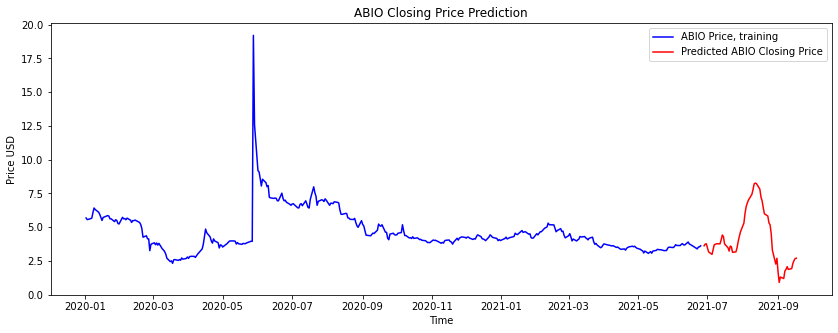

In [2]:
# %%
# cell is used to predict a particular symbol
# starts w/ an API call, to get the most recent data
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import datetime
import os
from sklearn.metrics import mean_squared_error
model_settings = {'epochs': 50, 'batch_size': 100, 'train_test_ratio': 0.7, 'hidden_layers': 3, 'units': 100, 'n_lags': 2}


# dataset is based on symbols related to CTXR
# Choose what Symbol you would like to predict:
symbol = 'CTXR'     # change to whatever symbol in your dataframe you'd like to attempt to predict.
start_date = "2020-01-01"
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_settings['start_date'] = start_date
model_settings['end_date'] = current_date

# next cell
conn = sqlite3.connect('stockPrediction_062721.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{symbol}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

# next
# reset the index
df = df.reset_index()

# next
# convert to datetime
df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

# reshape
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[start_date:current_date]  # date range from 2019-01-01 to 2021-05-31

# set a threshold of how many np.nan you are willing to work with
close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

# forward fill in np.nan values in columns not previously dropped.
close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)

# now starts the actual predictions

symbol = 'ABIO'

current_date = datetime.datetime.now().strftime("%Y-%m-%d")

if symbol in close_df.columns:
    data_size = len(close_df)

    # we will still need to bring our standard array of data w/ the prediction, as we can't just make a singular prediction
    training_data = close_df
else:
    data = yf.Ticker(symbol)
    data = data.history(
                    start = '2020-01-01',   # try this w/ more recent dates as well
                    end = current_date,
                    interval = '1d',
                    auto_adjust = True
    )
    new_data = pd.DataFrame(data['Close'].to_numpy(), columns=[symbol], index=None)
    new_data = new_data.set_index(close_df.index)

    data_size = len(close_df)

    # we will still need to bring our standard array of data w/ the prediction, as we can't just make a singular prediction
    training_data = close_df
    # training_data = training_data.drop(columns=training_data.columns[-2:-1])
    training_data[symbol] = new_data[symbol]
    # ensure that we're feeding the right data shape to the model
    if len(training_data.columns) > 438:
        excess = len(training_data.columns) - 438
        training_data = training_data.drop(columns=training_data.columns[-(excess + 1):-1])
        print(training_data.shape)

'''# regular script
data_size = len(close_df)

# we will still need to bring our standard array of data w/ the prediction, as we can't just make a singular prediction
training_data = close_df'''

# load saved model
regressor = tf.keras.models.load_model('model_20210627_162534')

# shape data to predict w/ 
# First, create a singular dataframe from the symbol you would like to predict vaues for
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()

minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)

# this section may not be necessary
train_scaled = train_scaled.values
n_lags = model_settings['n_lags'] # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

# this may also not be necessary

total_data = training_data
# inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = total_data[len(total_data) - 60:]
inputs = total_data
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(n_lags, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

# build, train model
# TRAINING THE MODEL

'''# LSTM architecture
regressor = tf.keras.Sequential()

# First layer, w/ dropout regularization
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(tf.keras.layers.Dropout(0.2))

# Second
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

# Third
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.5))

# Fourth
regressor.add(tf.keras.layers.LSTM(units=model_settings['units']))
regressor.add(tf.keras.layers.Dropout(0.5))

# Output layer
# based on other tutorials, setting Dense units to # of days outward I would like to predict
regressor.add(tf.keras.layers.Dense(units=1))

# Compile LSTM
regressor.compile(optimizer='adam', loss='mean_squared_error')

print("training model...")
regressor.fit(X_train, y_train, epochs=model_settings['epochs'], batch_size=model_settings['batch_size'], verbose=1, shuffle=True)
print("Training finished, moving to predictions.")'''

# this will require some manually debugging, I'm sure of it

# this part is absolutely necessary
predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
# predicted_price = predicted_price.round(decimals=2)
# predicted_price.index = test_data.index

total_data = total_data.reset_index()
for i in range(len(predicted_price)):
    try:
        future_date = predicted_price['price_datetime'].iloc[i -1] + datetime.timedelta(days=1)
    except:
        future_date = total_data.price_datetime.iloc[-1] + datetime.timedelta(days=1)
    
    while future_date.weekday() in [5,6]:
        future_date = future_date + datetime.timedelta(days=1)
    future_date = future_date.strftime('%Y-%m-%d')
    future_date = pd.to_datetime(future_date, format='%Y-%m-%d')
    future_dates = {'price_datetime': future_date}
    '''try:
        future_dates_df = future_dates_df.append(future_dates, ignore_index=True)
    except:
        future_dates_df = pd.DataFrame.from_dict(future_dates)'''
    predicted_price = predicted_price.append(future_dates, ignore_index=True)
    predicted_price['price_datetime'].iloc[i] = future_date
# predicted_price['price_datetime'] = future_dates_df['price_datetime']
# this is so that when looping this code it doesn't cause problems
total_data = total_data.set_index('price_datetime')

predicted_price = predicted_price.set_index('price_datetime')
predicted_price = predicted_price.dropna()

# this below shifts the data to align w/ the last point in the training data
# this may not get used
last_value = training_data[symbol].iloc[-1]
difference = last_value - predicted_price[f'{symbol}_predicted'].iloc[0]
predicted_price[f'{symbol}_predicted'] = predicted_price[f'{symbol}_predicted'] + difference

plt.figure(figsize=(14,5))
#mse = mean_squared_error(y_test, predicted_price)
plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
plt.plot(predicted_price[f'{symbol}_predicted'].iloc[:60], color = 'red', label= f'Predicted {symbol} Closing Price')
# plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
# plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
plt.title(f'{symbol} Closing Price Prediction')
plt.xlabel("Time")
plt.ylabel('Price USD')
plt.legend()
plt.show()

In [11]:
print('Predicted Max:', predicted_price[f'{symbol}_predicted'].iloc[:60].max(), 'Predicted Max Date:', predicted_price[f'{symbol}_predicted'].iloc[:60].idxmax(), 'Percent increase to max from current:', ((predicted_price[f'{symbol}_predicted'].iloc[:60].max() - data['Close'].iloc[-1]) / data['Close'].iloc[-1] * 100))

Predicted Max: 2.6013898849487305 Predicted Max Date: 2021-08-11 00:00:00 Percent increase to max from current: 16.13347651220442


In [16]:
for i in close_df.columns:
    print(i)

ABEO
ABIO
ABMC
ABMT
ABUS
ACER
ACHFF
ACRX
ACST
ACUR
ADIL
ADMA
ADMP
ADMS
ADMT
ADXS
AEMD
AEZS
AGE
AGEN
AGRX
AGTC
AHPI
AIKI
AIM
AKBA
AKTX
ALEAF
ALID
ALIM
ALNA
ALRN
AMPE
AMRX
AMS
ANIX
APEN
APM
APOP
APPB
APTO
APTX
AQSZF
ARAY
ARFXF
ARHH
ARMP
ARPO
ARTH
ARTL
ASLN
ASRT
ATHE
ATHX
ATMS
ATOS
ATRS
AVCO
AVGR
AXIM
AZRX
BBI
BBRRF
BCDA
BCLI
BDSI
BETRF
BHNGF
BICTF
BICX
BIMI
BIOAF
BIOC
BIOL
BKD
BLCM
BLRX
BLU
BMMJ
BMRA
BNGO
BNKL
BNTC
BNVIF
BPTH
BSGM
BSTG
BTCY
BUDZ
BXRX
CALA
CANB
CANF
CAPR
CASI
CATB
CBDS
CBLI
CBWTF
CCM
CDTX
CDXC
CDXI
CEMI
CERC
CFMS
CHMA
CHOOF
CJJD
CKPT
CLBS
CLRB
CLSD
CLSH
CLSN
CLVS
CMRX
CMXC
CNBX
CNSP
CO
COCP
CPHI
CPIX
CPRX
CRBP
CRTPF
CRVS
CSLT
CTIC
CTXR
CURR
CVALF
CVGRF
CVSI
CWBHF
CWBR
CYCN
CYTR
DARE
DBCCF
DBVT
DECN
DFFN
DRRX
DVAX
DVCR
DYNT
EARS
ECOR
EDSA
ELOX
ELTP
EMHTF
ENDV
ENOB
ENTX
ENZ
ENZN
EOLS
ESMC
ETTX
EVFM
EVGN
EVOK
EXDI
EXPFF
EYEG
EYES
FBIO
FFNTF
FIORF
FLOOF
FLURF
GALT
GEG
GENE
GERN
GGTTF
GHSI
GLMD
GLYC
GNBT
GNCA
GNFT
GNLN
GNPX
GRYN
GTBP
HAPP
HBIO
HBORF
HEPA
HERTF
HEXO
HITIF
HLYK
